In [1]:
!pip install fastbook --upgrade
!pip install fastai --upgrade

     |████████████████████████████████| 727kB 15.3MB/s 
     |████████████████████████████████| 1.2MB 34.0MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 194kB 49.3MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.2.2)


## Downloading images with DDG

In [2]:
from fastbook import *

In [3]:
# Copied from: https://github.com/fastai/fastbook/blob/master/utils.py

def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

Downloading multiple files

In [4]:
def download_ddg_images(urls, filepath, filename_prefix):
    """ Download images from urls into designated filepath with filename prefix

    Arguments
        urls (list): list of url strings.
        filepath (string/Path): filepath to where image should be saved.
        filename_prefix (string): beginning of image filename.

    Returns
        Nothing. Images are saved in filepath.
    """
    urls_size = len(urls)
    for idx, url in enumerate(urls):
        try:
            download_url(url, f"{str(filepath)}/{filename_prefix}{idx}.jpg")
            if idx%10==0:
                print(f"{idx}/{urls_size}")
        except:
            continue

In [5]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [6]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images_ddg(f"{o} bear", max_n=100)
        download_ddg_images(urls, dest, o)

0/100


10/100


20/100


30/100


40/100


50/100


60/100


70/100


80/100


90/100


0/100


10/100


20/100


30/100


40/100


50/100


60/100


70/100


80/100


90/100


0/100


10/100


20/100


30/100


40/100


50/100


60/100


70/100


80/100


90/100


In [7]:
fns = get_image_files(path)

In [8]:
fns

(#293) [Path('bears/black/black7.jpg'),Path('bears/black/black75.jpg'),Path('bears/black/black50.jpg'),Path('bears/black/black51.jpg'),Path('bears/black/black0.jpg'),Path('bears/black/black96.jpg'),Path('bears/black/black83.jpg'),Path('bears/black/black31.jpg'),Path('bears/black/black67.jpg'),Path('bears/black/black45.jpg')...]

In [9]:
failed = verify_images(fns)

In [10]:
failed

(#4) [Path('bears/black/black74.jpg'),Path('bears/black/black95.jpg'),Path('bears/teddy/teddy47.jpg'),Path('bears/grizzly/grizzly93.jpg')]

In [11]:
# unlink failed images
failed.map(Path.unlink);

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
dls = bears.dataloaders(path)

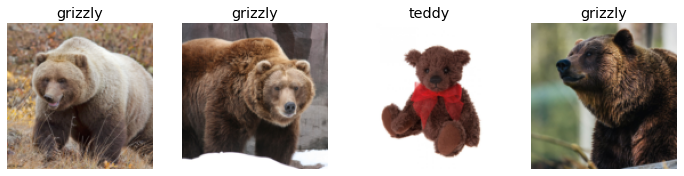

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

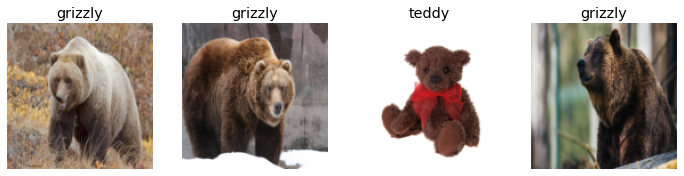

In [15]:
# Pad images with squishing/stretching
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

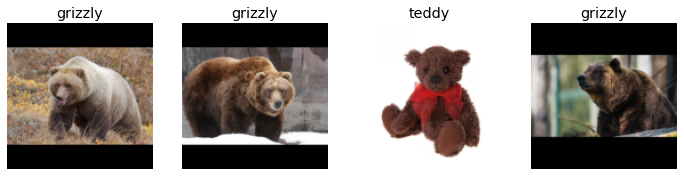

In [16]:
# Pad images with zeros (black)
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

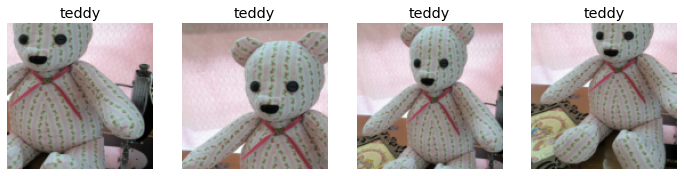

In [17]:
# Replace Resize with RandomResizedCrop
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

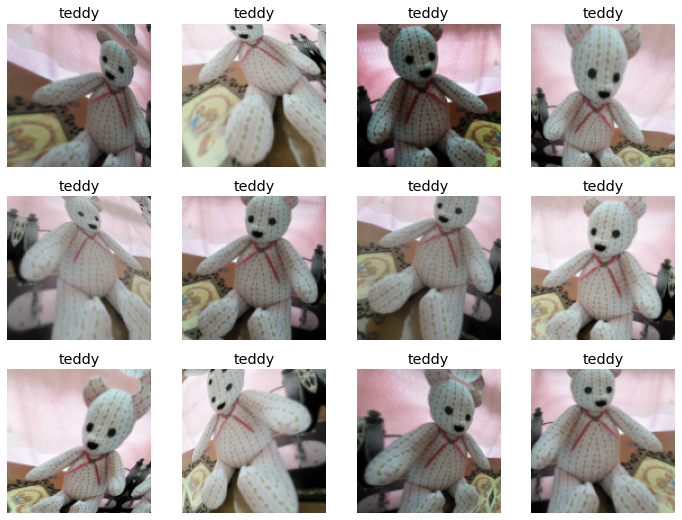

In [22]:
# Data augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=12, nrows=3, unique=True)

In [21]:
doc(aug_transforms)

## Training the Model

In [23]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


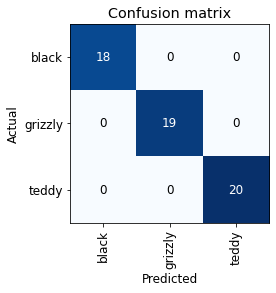

In [25]:
# Create confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

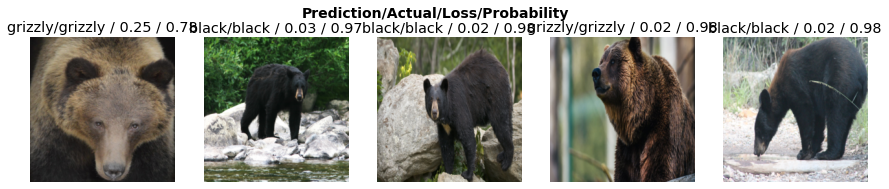

In [26]:
interp.plot_top_losses(5, nrows=1)

In [30]:
#from fastai.vision.all import *
from fastai.vision.widgets import * # required for ImageClassifierCleaner

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

If I need to delete, I would run the following:
```python
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()
```

To move images to different categories:
```python
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)
```

In [32]:
# Export model, including how DataLoaders were defined
# creates export.pkl file
learn.export()

In [33]:
# check that file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Inference

In [34]:
# load inference learner from exported file
learn_inf = load_learner(path/'export.pkl')

In [35]:
# Get prediction via inference
learn_inf.predict('bears/black/black0.jpg')

('black', tensor(0), tensor([9.9999e-01, 4.1752e-06, 1.1491e-06]))

In [36]:
# See stored list of all possible categories
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Creating Notebook App

In [37]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
# Now grab the image
img = PILImage.create(btn_upload.data[-1])

In [40]:
# We can use an Output widget to display it
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
# Get our prediction
pred, pred_idx, probs = learn_inf.predict(img)

In [42]:
# Use a Label to display them
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9998')

In [45]:
# Button to do the classification
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [46]:
# Click event handler - function called when Classify Button is pressed
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [47]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])